In [3]:
!pip install altair

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import nltk,spacy,re
from  nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from spacy.tokens import span
from spacy import displacy
from spacy.displacy.render import EntityRenderer
nlp=spacy.load("en_core_web_sm")
from bs4 import BeautifulSoup
import altair as alt
import gensim
from gensim import *
from gensim.models import Word2Vec,KeyedVectors
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from warnings import simplefilter
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import seaborn as sns
sns.set_style('darkgrid')
from sklearn .decomposition import PCA
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


In [ ]:
tweets_df = pd.read_csv('/content/drive/My Drive/Tweets-A.csv')

In [ ]:
tweets_df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,24/02/15 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
tweets_df.columns

Index(['tweet_id', 'airline_sentiment', 'name', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           14640 non-null  float64
 1   airline_sentiment  14640 non-null  object 
 2   name               14640 non-null  object 
 3   text               14640 non-null  object 
 4   tweet_coord        1019 non-null   object 
 5   tweet_created      14640 non-null  object 
 6   tweet_location     9907 non-null   object 
 7   user_timezone      9820 non-null   object 
dtypes: float64(1), object(7)
memory usage: 915.1+ KB


In [ ]:
#Missing data percentage list
for col in tweets_df.columns:
    pct_missing = np.mean(tweets_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

tweet_id - 0.0%
airline_sentiment - 0.0%
name - 0.0%
text - 0.0%
tweet_coord - 93.0%
tweet_created - 0.0%
tweet_location - 32.0%
user_timezone - 33.0%


In [ ]:
#TweetId is primary key and Tweet_cord has more than 80% of missing rows, so dropped them
tsa_df = tweets_df.drop(columns = ['tweet_id','tweet_coord'])
tsa_df.head()

,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone
0,neutral,cairdin,@VirginAmerica What @dhepburn said.,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,positive,jnardino,@VirginAmerica plus you've added commercials t...,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,negative,jnardino,@VirginAmerica it's really aggressive to blast...,24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,negative,jnardino,@VirginAmerica and it's a really big bad thing...,24/02/15 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
#Checking the occurence of each location
tsa_df["tweet_location"].value_counts()

Boston, MA                     157
New York, NY                   156
Washington, DC                 150
New York                       127
USA                            126
                              ... 
grand rapids, michigan           1
Lubbock, TX                      1
MA & NJ                          1
New York, NY, DC & Maryland      1
Brooklin, New York               1
Name: tweet_location, Length: 3081, dtype: int64

In [ ]:
#Boston, MA occured many times so null values can be replaced by Boston, MA in tweet_location column
tsa_df['tweet_location'].fillna('Boston, MA', inplace = True)

In [ ]:
#Checking the occurence of each timezone
tsa_df["user_timezone"].value_counts()

Eastern Time (US & Canada)    3744
Central Time (US & Canada)    1931
Pacific Time (US & Canada)    1208
Quito                          738
Atlantic Time (Canada)         497
                              ... 
Midway Island                    1
Prague                           1
Warsaw                           1
Pretoria                         1
America/Atikokan                 1
Name: user_timezone, Length: 85, dtype: int64

In [ ]:
#Eastern Time (US & Canada) occured many times so null values can be replaced by Eastern Time (US & Canada) in user_timezone column
tsa_df['user_timezone'].fillna('Eastern Time (US & Canada)', inplace = True)

In [ ]:
#Column ['Text'] pre-processing by converting it to lower case
tsa_df.text = tsa_df.text.apply(lambda text:text.lower() if type(text) == str else text)

In [ ]:
def decontracted(phrase):

    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
tsa_df['text']

0                      @virginamerica what @dhepburn said.
1        @virginamerica plus you've added commercials t...
2        @virginamerica i didn't today... must mean i n...
3        @virginamerica it's really aggressive to blast...
4        @virginamerica and it's a really big bad thing...
                               ...                        
14635    @americanair thank you we got on a different f...
14636    @americanair leaving over 20 minutes late flig...
14637    @americanair please bring american airlines to...
14638    @americanair you have my money, you change my ...
14639    @americanair we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [ ]:
#HREF Links Removal
tsa_df.text = tsa_df.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))

In [ ]:
#HTML Text Removal
tsa_df.text = tsa_df.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

In [ ]:
#HashTags Separation And Merging
tsa_df['hashtags'] = [ [ tag[1: ] for tag in i.split() if tag.startswith('#') ] for i in tsa_df.text ]

In [ ]:
#@Entities Separation And Merging
tsa_df['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in tsa_df.text ]

In [ ]:
#Punctuations Removal
tsa_df.text = tsa_df.text.str.replace('[^\w\s]','')

In [ ]:
#Tokenization
tsa_df['tokenized_text'] = [[word for word in word_tokenize(i)] for i in tsa_df.text]

In [ ]:
#StopWords Removal
tsa_df.text = [ " ".join(([word for word in word_tokenize(i) if not word in list((stopwords.words('english')))]))  for i in tsa_df.text ]

In [ ]:
#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
tsa_df['lemmatized_text'] = tsa_df.text.apply(lambda text: lemmatizer.lemmatize(text))

In [ ]:
#pos tagging
tagged_text = tsa_df.tokenized_text.apply(lambda tokenized_text: nltk.pos_tag(tokenized_text))

In [ ]:
tsa_df.head()

,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone,hashtags,tags,tokenized_text,lemmatized_text
0,neutral,cairdin,virginamerica dhepburn said,24/02/15 11:35,"Boston, MA",Eastern Time (US & Canada),[],"[virginamerica, dhepburn]","[virginamerica, what, dhepburn, said]",virginamerica dhepburn said
1,positive,jnardino,virginamerica plus youve added commercials exp...,24/02/15 11:15,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, plus, youve, added, commercial...",virginamerica plus youve added commercials exp...
2,neutral,yvonnalynn,virginamerica didnt today must mean need take ...,24/02/15 11:15,Lets Play,Central Time (US & Canada),[],[virginamerica],"[virginamerica, i, didnt, today, must, mean, i...",virginamerica didnt today must mean need take ...
3,negative,jnardino,virginamerica really aggressive blast obnoxiou...,24/02/15 11:15,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, its, really, aggressive, to, b...",virginamerica really aggressive blast obnoxiou...
4,negative,jnardino,virginamerica really big bad thing,24/02/15 11:14,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, and, its, a, really, big, bad,...",virginamerica really big bad thing


In [ ]:
#Total no. of positive tweets
tsa_df[(tsa_df['airline_sentiment'] == 'positive') ].count()[['airline_sentiment']]

airline_sentiment    2363
dtype: int64

In [ ]:
#All the positive tweets
tsa_df[(tsa_df['airline_sentiment'] == 'positive')].count().head()

airline_sentiment    2363
name                 2363
text                 2363
tweet_created        2363
tweet_location       2363
dtype: int64

In [ ]:
#Total no. of neutral tweets
tsa_df[(tsa_df['airline_sentiment'] == 'neutral') ].count()[['airline_sentiment']]

airline_sentiment    3099
dtype: int64

In [ ]:
#All the neutral tweets
tsa_df[(tsa_df['airline_sentiment'] == 'neutral')].head()

,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone,hashtags,tags,tokenized_text,lemmatized_text
0,neutral,cairdin,virginamerica dhepburn said,24/02/15 11:35,"Boston, MA",Eastern Time (US & Canada),[],"[virginamerica, dhepburn]","[virginamerica, what, dhepburn, said]",virginamerica dhepburn said
2,neutral,yvonnalynn,virginamerica didnt today must mean need take ...,24/02/15 11:15,Lets Play,Central Time (US & Canada),[],[virginamerica],"[virginamerica, i, didnt, today, must, mean, i...",virginamerica didnt today must mean need take ...
7,neutral,pilot,virginamerica really missed prime opportunity ...,24/02/15 11:12,Los Angeles,Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, really, missed, a, prime, oppo...",virginamerica really missed prime opportunity ...
10,neutral,idk_but_youtube,virginamerica know suicide second leading caus...,24/02/15 10:48,1/1 loner squad,Eastern Time (US & Canada),[],[virginamerica],"[virginamerica, did, you, know, that, suicide,...",virginamerica know suicide second leading caus...
23,neutral,rjlynch21086,virginamerica making boslas non stop permanent...,24/02/15 8:27,"Boston, MA",Eastern Time (US & Canada),[],[virginamerica],"[virginamerica, will, you, be, making, boslas,...",virginamerica making boslas non stop permanent...


In [ ]:
#Total no. of negative tweets
tsa_df[(tsa_df['airline_sentiment'] == 'negative') ].count()[['airline_sentiment']]

airline_sentiment    9178
dtype: int64

In [ ]:
#All the negative tweets
tsa_df[(tsa_df['airline_sentiment'] == 'negative')].head()

,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone,hashtags,tags,tokenized_text,lemmatized_text
3,negative,jnardino,virginamerica really aggressive blast obnoxiou...,24/02/15 11:15,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, its, really, aggressive, to, b...",virginamerica really aggressive blast obnoxiou...
4,negative,jnardino,virginamerica really big bad thing,24/02/15 11:14,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, and, its, a, really, big, bad,...",virginamerica really big bad thing
5,negative,jnardino,virginamerica seriously would pay 30 flight se...,24/02/15 11:14,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, seriously, would, pay, 30, a, ...",virginamerica seriously would pay 30 flight se...
15,negative,smartwatermelon,virginamerica sfopdx schedule still mia,24/02/15 10:01,"palo alto, ca",Pacific Time (US & Canada),[],[virginamerica],"[virginamerica, sfopdx, schedule, is, still, mia]",virginamerica sfopdx schedule still mia
17,negative,heatherovieda,virginamerica flew nyc sfo last week couldnt f...,24/02/15 9:39,this place called NYC,Eastern Time (US & Canada),[],[virginamerica],"[virginamerica, i, flew, from, nyc, to, sfo, l...",virginamerica flew nyc sfo last week couldnt f...


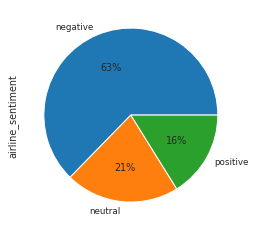

In [ ]:
#Graphical representation of positive, neutral and negative tweets
tsa_df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

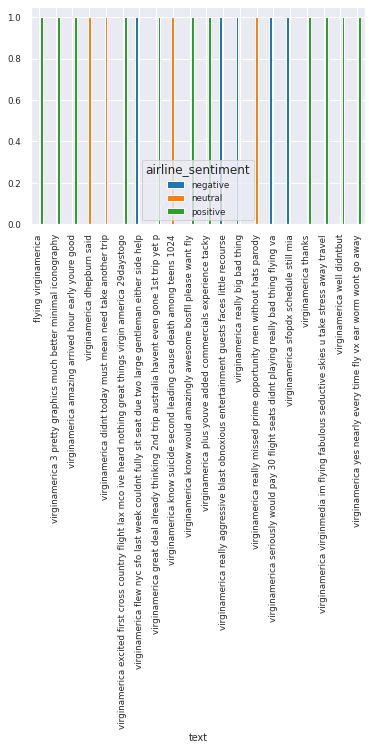

In [ ]:
airline_sentiment = tsa_df.groupby([tsa_df.text, tsa_df.airline_sentiment[:20]]).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [ ]:
alt.Chart(tsa_df[:25]).mark_point(filled=True).encode(
    alt.X('text'),
    alt.Y('airline_sentiment'),
    alt.Size('text'),
    alt.Color('text'),
    )

alt.Chart(...)

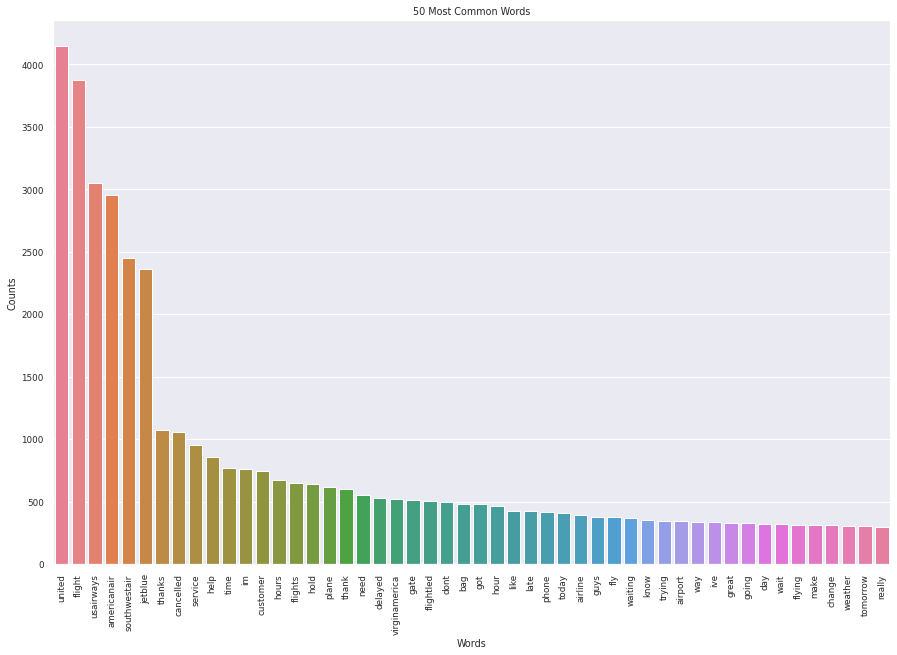

In [ ]:
# Load the library with the CountVectorizer method



def common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:50]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(None, figsize = (15, 10))
    plt.subplot(title = '50 Most Common Words')
    sns.set_context("notebook", font_scale = 0.8, rc={"lines.linewidth": 1})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tsa_df['text'])

# Visualise the 50 most common words
common_words(count_data, count_vectorizer)

In [ ]:

 
# Helper function
def topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic %d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found : ")
topics(lda, count_vectorizer, number_words)

Topics found : 

Topic 0:
americanair flight usairways hold cancelled hours flightled late time hour

Topic 1:
flight jetblue usairways cancelled americanair delayed southwestair tomorrow im problems

Topic 2:
jetblue americanair united flight plane way airport guys fly love

Topic 3:
united virginamerica americanair bag good thanks time dont flights usairways

Topic 4:
united americanair usairways help flight cancelled need email minutes number

Topic 5:
jetblue fleek fleets thank rt united thanks guys credit virginamerica

Topic 6:
united flight delayed plane time thanks gate late bag im

Topic 7:
service usairways customer united americanair thanks worst luggage like baggage

Topic 8:
southwestair thanks thank dm flying guys usairways follow great americanair

Topic 9:
southwestair americanair flight usairways united want change people boarding app


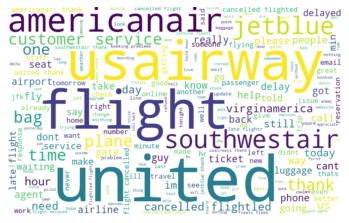

In [ ]:
# WordCloudVisualisation

allWords = ' '.join([twts for twts in tsa_df.text])

wordCloud = WordCloud(background_color = 'white', width=800, height=500, random_state=21, max_font_size=150).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()



In [ ]:
# entity analysis

nlp.max_length = 18000000

lower = lambda X: X.lower()
df = pd.DataFrame(tsa_df['text'].apply(lower))
df.columns = ['ent_text']
df.head(25)
def extract_named_ents(text):
  return[(ent.text,ent.start_char,ent.end_char,ent.label_)for ent in nlp(text).ents]

def add_named_ents(df):
  df['named_ents']=df['ent_text'].apply(extract_named_ents)
add_named_ents(df)
df.head()

,ent_text,named_ents
0,virginamerica dhepburn said,"[(virginamerica dhepburn, 0, 22, PERSON)]"
1,virginamerica plus youve added commercials exp...,[]
2,virginamerica didnt today must mean need take ...,"[(virginamerica, 0, 13, ORG), (today, 20, 25, ..."
3,virginamerica really aggressive blast obnoxiou...,[]
4,virginamerica really big bad thing,[]


In [ ]:
df_target = tsa_df.airline_sentiment.replace({'positive':1,'neutral':0,"negative":-1})
df_target.value_counts()

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [ ]:
#Model training using bag of words

#Tokenizer to remove unwanted elements from text like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
corpus= cv.fit_transform(tsa_df.text)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus, df_target, test_size=0.20, stratify = df_target, random_state=52)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
Accuracy_lr = accuracy_score(y_test,y_pred)
print("\nAccuracy of Logisticregression Model: {}\n".format(Accuracy_lr))
print(classification_report(y_test,y_pred))

Confusion Matrix
[[1623  162   51]
 [ 212  343   65]
 [  93   61  318]]

Accuracy of Logisticregression Model: 0.7800546448087432

              precision    recall  f1-score   support

          -1       0.84      0.88      0.86      1836
           0       0.61      0.55      0.58       620
           1       0.73      0.67      0.70       472

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.77      0.78      0.78      2928



In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
Accuracy_dt= accuracy_score(y_test,y_pred)
print("\nAccuracy of DecisionTreeClassifier Model: {}\n".format(Accuracy_dt))
print(classification_report(y_test,y_pred))

Confusion Matrix
[[1451  282  103]
 [ 208  319   93]
 [ 105   90  277]]

Accuracy of DecisionTreeClassifier Model: 0.6991120218579235

              precision    recall  f1-score   support

          -1       0.82      0.79      0.81      1836
           0       0.46      0.51      0.49       620
           1       0.59      0.59      0.59       472

    accuracy                           0.70      2928
   macro avg       0.62      0.63      0.63      2928
weighted avg       0.71      0.70      0.70      2928



In [ ]:
# Random Forest Classifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
Accuracy_rf = accuracy_score(y_test,y_pred)
print("\nAccuracy of RandomForestClassifier Model: {}\n".format(Accuracy_rf))
print(classification_report(y_test,y_pred))

Confusion Matrix
[[1628  153   55]
 [ 244  300   76]
 [ 121   69  282]]

Accuracy of RandomForestClassifier Model: 0.7547814207650273

              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      1836
           0       0.57      0.48      0.53       620
           1       0.68      0.60      0.64       472

    accuracy                           0.75      2928
   macro avg       0.69      0.66      0.67      2928
weighted avg       0.74      0.75      0.75      2928



In [ ]:
# Support Vector Machine
sup =svm.SVC()
sup.fit(X_train,y_train)
y_pred = sup.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
Accuracy_svm = accuracy_score(y_test,y_pred)
print("\nAccuracy of SupportVectorMachine Model: {}\n".format(Accuracy_svm))
print(classification_report(y_test,y_pred))

Confusion Matrix
[[1712   91   33]
 [ 302  266   52]
 [ 153   55  264]]

Accuracy of SupportVectorMachine Model: 0.7657103825136612

              precision    recall  f1-score   support

          -1       0.79      0.93      0.86      1836
           0       0.65      0.43      0.52       620
           1       0.76      0.56      0.64       472

    accuracy                           0.77      2928
   macro avg       0.73      0.64      0.67      2928
weighted avg       0.75      0.77      0.75      2928



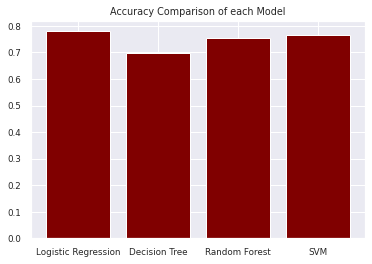

In [ ]:
Accuracy = [Accuracy_lr, Accuracy_dt, Accuracy_rf, Accuracy_svm]
Methods = ['Logistic Regression','Decision Tree','Random Forest','SVM']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy, color = 'maroon')
plt.xticks(Accuracy_pos, Methods)
plt.title('Accuracy Comparison of each Model')
plt.show()

In [ ]:
#Model training using TF-IDF

tf = TfidfVectorizer()
text_tf = tf.fit_transform(tsa_df['text'])

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    text_tf, df_target, test_size = 0.20, random_state = 70)

In [ ]:
lr_tf = LogisticRegression()
lr_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = lr_tf.predict(X_test_tf)
print("Confusion Matrix")
print(confusion_matrix(y_test_tf,y_pred_tf))
Accuracy_tf_lr = accuracy_score(y_test_tf, y_pred_tf)
print("\nAccuracy of Logisticregression Model: {}\n".format(Accuracy_tf_lr))
print(classification_report(y_test_tf,y_pred_tf))

Confusion Matrix
[[1758   61   32]
 [ 315  276   36]
 [ 130   46  274]]

Accuracy of Logisticregression Model: 0.7882513661202186

              precision    recall  f1-score   support

          -1       0.80      0.95      0.87      1851
           0       0.72      0.44      0.55       627
           1       0.80      0.61      0.69       450

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



In [ ]:
dt_tf = DecisionTreeClassifier(criterion = 'entropy', random_state = 52)
dt_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = dt_tf.predict(X_test_tf)
print("Confusion Matrix")
print(confusion_matrix(y_test_tf,y_pred_tf))
Accuracy_tf_dt = accuracy_score(y_test_tf, y_pred_tf)
print("\nAccuracy of Logisticregression Model: {}\n".format(Accuracy_tf_dt))
print(classification_report(y_test_tf,y_pred_tf))

Confusion Matrix
[[1479  256  116]
 [ 319  229   79]
 [ 127   82  241]]

Accuracy of Logisticregression Model: 0.6656420765027322

              precision    recall  f1-score   support

          -1       0.77      0.80      0.78      1851
           0       0.40      0.37      0.38       627
           1       0.55      0.54      0.54       450

    accuracy                           0.67      2928
   macro avg       0.57      0.57      0.57      2928
weighted avg       0.66      0.67      0.66      2928



In [ ]:
# Random Forest Classifier

rf_tf = RandomForestClassifier()
rf_tf.fit(X_train_tf,y_train_tf)
y_pred_tf = rf_tf.predict(X_test_tf)
print("Confusion Matrix")
print(confusion_matrix(y_test_tf,y_pred_tf))
Accuracy_tf_rf = accuracy_score(y_test_tf, y_pred_tf)
print("\nAccuracy of RandomForestClassifier Model: {}\n".format(Accuracy_tf_rf))
print(classification_report(y_test_tf,y_pred_tf))

Confusion Matrix
[[1765   57   29]
 [ 364  221   42]
 [ 161   52  237]]

Accuracy of RandomForestClassifier Model: 0.7592213114754098

              precision    recall  f1-score   support

          -1       0.77      0.95      0.85      1851
           0       0.67      0.35      0.46       627
           1       0.77      0.53      0.63       450

    accuracy                           0.76      2928
   macro avg       0.74      0.61      0.65      2928
weighted avg       0.75      0.76      0.73      2928



In [ ]:
# Support Vector Machine
sup_tf =svm.SVC()
sup_tf.fit(X_train_tf,y_train_tf)
y_pred_tf = sup_tf.predict(X_test_tf)
print("Confusion Matrix")
print(confusion_matrix(y_test_tf,y_pred_tf))
Accuracy_tf_svm = accuracy_score(y_test_tf, y_pred_tf)
print("\nAccuracy of SupportVectorMachine Model: {}\n".format(Accuracy_tf_svm))
print(classification_report(y_test_tf,y_pred_tf))

Confusion Matrix
[[1793   32   26]
 [ 373  219   35]
 [ 154   33  263]]

Accuracy of SupportVectorMachine Model: 0.7769808743169399

              precision    recall  f1-score   support

          -1       0.77      0.97      0.86      1851
           0       0.77      0.35      0.48       627
           1       0.81      0.58      0.68       450

    accuracy                           0.78      2928
   macro avg       0.79      0.63      0.67      2928
weighted avg       0.78      0.78      0.75      2928



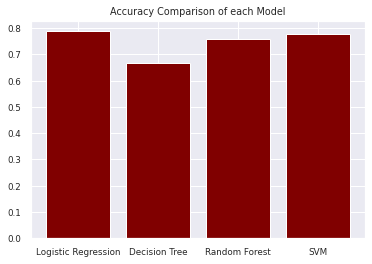

In [ ]:
Accuracy = [Accuracy_tf_lr, Accuracy_tf_dt, Accuracy_tf_rf, Accuracy_tf_svm]
Methods = ['Logistic Regression','Decision Tree','Random Forest','SVM']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy,color = 'maroon')
plt.xticks(Accuracy_pos, Methods)
plt.title('Accuracy Comparison of each Model')
plt.show()

In [ ]:
# word2vec model training
textwv = tsa_df['text'].values
nltk.download('punkt')
nerVec=[nltk.word_tokenize(text)for text in textwv]



#train the word2vec model
model = Word2Vec(nerVec,min_count=10,size=300,window=5,sg=1)	
model.wv.most_similar('virginamerica')
words=list(model.wv.vocab)
print(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['virginamerica', 'said', 'plus', 'youve', 'added', 'experience', 'didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'really', 'entertainment', 'little', 'big', 'bad', 'thing', 'seriously', 'would', 'pay', '30', 'flight', 'seats', 'flying', 'yes', 'nearly', 'every', 'time', 'fly', 'wont', 'go', 'away', 'missed', 'opportunity', 'without', 'well', 'amazing', 'arrived', 'hour', 'early', 'youre', 'good', 'know', 'second', 'cause', 'death', 'among', '3', 'pretty', 'much', 'better', 'great', 'deal', 'already', 'thinking', '2nd', 'australia', 'havent', 'even', 'gone', '1st', 'yet', 'im', 'skies', 'u', 'travel', 'thanks', 'schedule', 'still', 'mia', 'excited', 'first', 'cross', 'country', 'lax', 'mco', 'ive', 'heard', 'nothing', 'things', 'virgin', 'america', 'flew', 'nyc', 'sfo', 'last', 'week', 'couldnt', 'sit', 'seat', 'due', 'two', 'large', 'either', 'side', 'hel

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


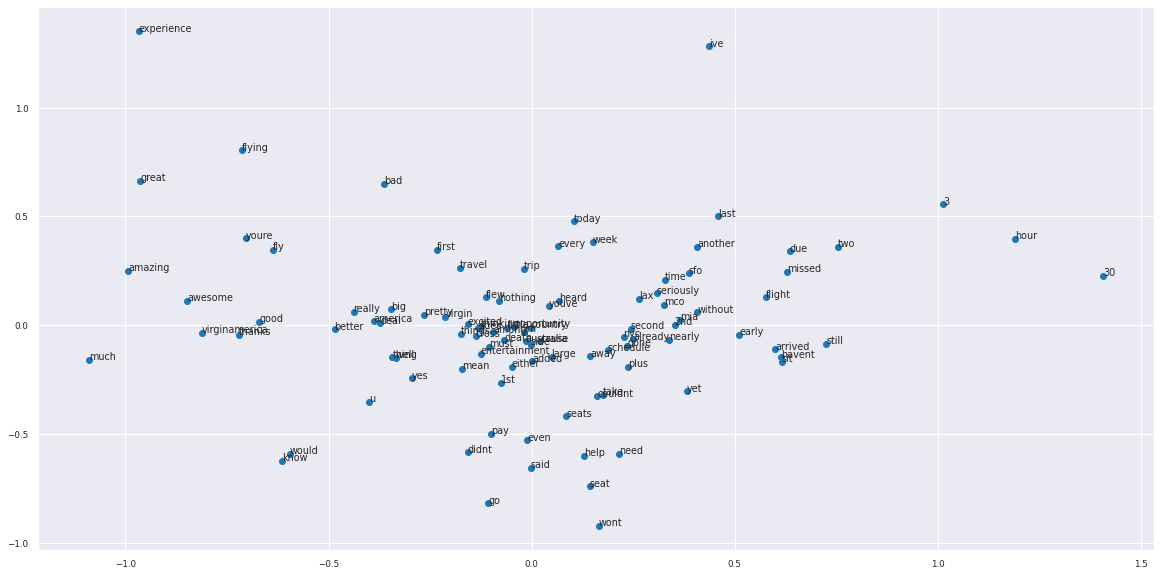

In [ ]:
X=model[model.wv.vocab]

pca=PCA(n_components=2)
result=pca.fit_transform(X[:100])
plt.figure(figsize=(20,10))
plt.scatter(result[:, 0],result[:, 1])
for i,word in enumerate(words[:100]):
  plt.annotate(word,xy=(result[i, 0],result[i, 1]))
plt.show()

In [2]:
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz", binary=True)
textwv = tsa_df.text.apply(lambda text: re.sub(r'[a-zA-Z0-9]+', '', text))
corpus_wv = [nltk.word_tokenize(text)for text in textwv]
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(corpus_wv, df_target, test_size = 0.20, random_state = 88)

In [1]:
lr_wv = LogisticRegression()
lr_wv.fit(X_train_wv, y_train_wv)
y_pred_wv = lr_wv.predict(X_test_wv)
print("Confusion Matrix")
print(confusion_matrix(y_test_wv,y_pred_wv))
Accuracy_lr_wv = accuracy_score(y_test_wv, y_pred_wv)
print("\nAccuracy of Logisticregression Model: {}\n".format(Accuracy_lr_wv))
print(classification_report(y_test_wv,y_pred_wv))